In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import libpysal as lp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shapely.geometry as geom

## Data borrowing in supervised learning

In [4]:
listings = pd.read_csv('berlin-listings.csv.gz')
listings['geometry'] = listings[['longitude', 'latitude']].apply(geom.Point, axis=1)
listings = gpd.GeoDataFrame(listings)
listings.crs = {'init': 'epsg:4269'}
listings = listings.to_crs(epsg=3857)

C:\Users\Ivan\.conda\envs\geopandas_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

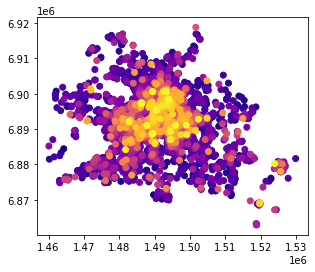

In [5]:
listings.sort_values('price').plot('price', cmap='plasma')

### Kernel regressions

A common way to allow observations to 'borrow strength' from nearby observations

When working with spatial data, there are two simultaneous senses of what is near:
- things that are similar in attribute (classical kernel regression)
- things that are similar in spatial position (spatial kernel regression)

Try to predict the log of an Airbnb's nightly price based on a few factors:
- accommodates: the number of people the aribnb can ccommodate
- review_scores_rating: the aggregate rating of the listing
- bedrooms: the number of bedrooms the airbnb has
- bathrooms: the number of bathrooms the airbnb has
- beds: the number of beds the airbnb has

In [6]:
model_data = listings[['accommodates', 'review_scores_rating', 'bedrooms', 'bathrooms', 'beds', 'price', 'geometry']].dropna()

In [7]:
Xnames = ['accommodates', 'review_scores_rating', 'bedrooms', 'bathrooms', 'beds']
X = model_data[Xnames].values
X = X.astype(float)
y = np.log(model_data[['price']].values)

In [10]:
# Since each listing has a location, extract the set of spatial coordiantes for each listing
coordinates = np.vstack(model_data.geometry.apply(lambda p: np.hstack(p.xy)).values)
coordinates

array([[1491246.09061424, 6906289.70588367],
       [1491523.30240249, 6905027.62143263],
       [1491598.86544802, 6907372.95286508],
       ...,
       [1486722.30038881, 6904230.45907474],
       [1483626.59167149, 6909789.47565835],
       [1484643.05708275, 6911169.65547772]])

scikit neighbor regressions contained in sklearn.neighbors module:
- KNeighborRegressor - uses a k-nearest neaigborhood of observations around each focal site
- RadiusNeighborsRegressor - considers all observations within a fixed radius around each focal site

In [9]:
import sklearn.neighbors as skn
import sklearn.metrics as skm

In [11]:
shuffle = np.random.permutation(len(y))
train, test = shuffle[:14000], shuffle[14000:]

Fitting three models:
- spatial: using inverse distance weighting on the nearest 500 neighbors geographical space
- attribute: using inverse distance weighting on the nearest 500 neighbors in attribute space
- both: using inverse distance weighting in both geographical and attribute space

In [12]:
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=500)
spatial = KNNR.fit(coordinates[train, :], y[train, :])

KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=500)
attribute = KNNR.fit(X[train, :], y[train, :])

KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=500)
both = KNNR.fit(np.hstack((coordinates, X))[train, :], y[train, :])

In [13]:
# To score them, grab their out of sample prediction accuracy and get their % explained variance
sp_ypred = spatial.predict(coordinates[test, :])
att_ypred = attribute.predict(X[test, :])
both_ypred = both.predict(np.hstack((X, coordinates))[test, :])

In [14]:
(skm.explained_variance_score(y[test, ], sp_ypred), skm.explained_variance_score(y[test, ], att_ypred), skm.explained_variance_score(y[test, ], both_ypred))

# spatial has 13% explained variance score, attribue has 28% and combination of both has -7%

(0.13396836294692194, 0.28798084440773786, -6.954263831460139e-09)

## Data borrowing

Using the weights matrix, you can construct neighborhood averages of the data matrix and use these as synthetic features in the model.

These often have a strong relationship to the outcome as well, since spatial data is often smooth and attributes of nearby sites often have a spillover impact on each other.

In [15]:
from libpysal.weights.util import fill_diagonal

In [16]:
# Construct a Kernel weight from the data, make it an adaptive Kernel bandwidht, and make sure that our kernle weights don't have any self-neighbors

In [17]:
kW = lp.weights.Kernel.from_dataframe(model_data, fixed=False, function='gaussian', k=100)
kW = fill_diagonal(kW, 0)

In [29]:
kW.transform = 'r'

In [30]:
WX = lp.weights.lag_spatial(kW, X)
WX[0], X[0]
# focal observation accommodates 2 people, but the 100 nearest airbnb listings accommodates approximately 3 people
# focal observation of the first listing has a rating of 100, but the 100 nearest airbnb listings have average rating of 92

(array([ 3.03579868, 92.77880216,  1.42062997,  1.0676283 ,  2.10405251]),
 array([  2., 100.,   1.,   1.,   2.]))

In [21]:
import statsmodels.api as sm

In [24]:
Xnames

['accommodates', 'review_scores_rating', 'bedrooms', 'bathrooms', 'beds']

In [25]:
Xtable = pd.DataFrame(X, columns=Xnames)
Xtable

,accommodates,review_scores_rating,bedrooms,bathrooms,beds
0,2.0,100.0,1.0,1.0,2.0
1,2.0,80.0,1.0,1.5,1.0
2,4.0,96.0,1.0,1.0,1.0
3,2.0,96.0,1.0,1.0,1.0
4,1.0,90.0,1.0,1.0,1.0
...,...,...,...,...,...
15511,1.0,80.0,2.0,1.0,1.0
15512,2.0,91.0,1.0,1.0,1.0
15513,2.0,93.0,1.0,1.0,1.0
15514,4.0,97.0,1.0,2.0,2.0


In [31]:
onlyX = sm.OLS(y, sm.add_constant(Xtable)).fit()
onlyX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     1269.
Date:                Sun, 26 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:23:40   Log-Likelihood:                -9260.8
No. Observations:               15516   AIC:                         1.853e+04
Df Residuals:                   15510   BIC:                         1.858e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9682      0.044     67.590      0.000       2.882       3.054
accommodates             0.1882      0.004     44.362      0.000       0.180       0.197
review_scores_rating     0.0033      0.000      7.378      0.000       0.002       0.004
bedrooms                 0.1427      0.008     18.503      0.000       0.128       0.158
bathrooms                0.0062      0.012      0.497      0.619      -0.018       0.031
beds                    -0.0482      0.005     -9.221      0.000      -0.058      -0.038
==============================================================================
Omnibus:                      156.822   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.898
Skew:                          -0.005   Prob(JB):                     1.82e-58
Kurtosis:                       3.641   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
WXtable = pd.DataFrame(WX, columns=['lag_{}'.format(name) for name in Xnames])

In [35]:
XWXtable = pd.concat((Xtable, WXtable), axis=1)
XWXtable.head()

,accommodates,review_scores_rating,bedrooms,bathrooms,beds,lag_accommodates,lag_review_scores_rating,lag_bedrooms,lag_bathrooms,lag_beds
0,2.0,100.0,1.0,1.0,2.0,3.035799,92.778802,1.420630,1.067628,2.104053
1,2.0,80.0,1.0,1.5,1.0,3.073963,93.584882,1.406256,1.055297,2.108723
2,4.0,96.0,1.0,1.0,1.0,2.929565,92.679820,1.386152,1.071107,2.049034
3,2.0,96.0,1.0,1.0,1.0,3.038135,92.830200,1.420787,1.067785,2.117734
4,1.0,90.0,1.0,1.0,1.0,3.076704,92.904373,1.428407,1.068349,2.118015


In [34]:
withWX = sm.OLS(y, sm.add_constant(XWXtable)).fit()
withWX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     714.0
Date:                Sun, 26 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:25:27   Log-Likelihood:                -8983.6
No. Observations:               15516   AIC:                         1.799e+04
Df Residuals:                   15505   BIC:                         1.807e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.1232      0.324     -0.380      0.704      -0.758       0.512
accommodates                 0.1829      0.004     43.757      0.000       0.175       0.191
review_scores_rating         0.0033      0.000      7.449      0.000       0.002       0.004
bedrooms                     0.1454      0.008     19.041      0.000       0.130       0.160
bathrooms                   -0.0152      0.012     -1.229      0.219      -0.039       0.009
beds                        -0.0448      0.005     -8.645      0.000      -0.055      -0.035
lag_accommodates             0.5391      0.031     17.533      0.000       0.479       0.599
lag_review_scores_rating     0.0151      0.003      4.640      0.000       0.009       0.021
lag_bedrooms                -0.0554      0.049     -1.141      0.254      -0.151       0.040
lag_bathrooms                1.0104      0.076     13.214      0.000       0.861       1.160
lag_beds                    -0.4703      0.034    -13.798      0.000      -0.537      -0.403
==============================================================================
Omnibus:                      172.165   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.805
Skew:                          -0.022   Prob(JB):                     1.30e-65
Kurtosis:                       3.678   Cond. No.                     1.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""